# DATASET

I am using "Annotated Corpus for Named Entity Recognition" from "https://www.kaggle.com/datasets/abhinavwalia95/entity-annotated-corpus" as it has most upvote.

This dataset is extracted from GMB(Groningen Meaning Bank) corpus which is tagged, annotated and built specifically to train the classifier to predict named entities such as name, location, etc.
All the entities are labeled using the BIO scheme, where each entity label is prefixed with either B or I letter. B- denotes the beginning and I- inside of an entity. The words which are not of interest are labeled with 0 – tag.

Below table shows the detailed information about labels of the words.

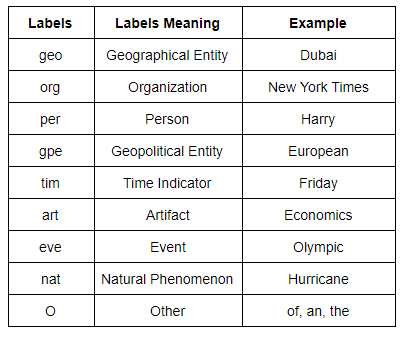

In [1]:
''' from google.colab import drive
drive.mount('/content/drive') '''

" from google.colab import drive\ndrive.mount('/content/drive') "

In [2]:
# you can give dataset path here
path="/content/drive/MyDrive/Colab Notebooks/MobileDEV/"
path_ner="ner.csv"
path_ner_dataset="ner_dataset.csv"

In [3]:
from IPython.display import clear_output 
!pip install sklearn-crfsuite
!pip install tabulate
!pip install nervaluate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from tabulate import tabulate
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn_crfsuite.metrics import flat_classification_report
import itertools
from nervaluate import Evaluator
from tqdm.auto import tqdm
import re
clear_output()
tqdm.pandas()

Auxiliary functions

In [4]:
tag_name_pattern = re.compile(r"(B|I)-")

def map_seq(seq, dictionary):
    return [dictionary[elem] for elem in seq]

In [5]:
# reading dataset from directory
df = pd.read_csv(path_ner_dataset, encoding="latin1")

In [6]:
''' # reading dataset from google drive
df = pd.read_csv(path+path_ner_dataset, encoding="latin1") '''

' # reading dataset from google drive\ndf = pd.read_csv(path+path_ner_dataset, encoding="latin1") '

In [7]:
# in order to delete blank word from dataset
lengths = df["Word"].apply(lambda x: len(x.split()))
df = df[lengths == 1]

#  hexadecimal escape sequence and Cancel Character will be deleted from dataset
chrs = ["\x85", "\x94"]
df = df[df["Word"].apply(lambda x: x not in chrs)]
df = df.reset_index(drop=True)

In [8]:
df = df.fillna(method="ffill")
df = df.astype({"Sentence #": "string", "Word": "string", "POS": "string", "Tag": "string"})

In [9]:
''' first_words_inds = df[df["Sentence #"].notna()].index.to_list()
for i in tqdm(range(len(first_words_inds)-1)):
    df["Sentence #"].loc[range(first_words_inds[i], first_words_inds[i+1])] = i
df["Sentence #"].loc[range(first_words_inds[-1],df["Sentence #"].shape[0])] = len(first_words_inds) - 1
df = df.astype({"Sentence #": int, "Word": "string", "POS": "string", "Tag": "string"}) '''

' first_words_inds = df[df["Sentence #"].notna()].index.to_list()\nfor i in tqdm(range(len(first_words_inds)-1)):\n    df["Sentence #"].loc[range(first_words_inds[i], first_words_inds[i+1])] = i\ndf["Sentence #"].loc[range(first_words_inds[-1],df["Sentence #"].shape[0])] = len(first_words_inds) - 1\ndf = df.astype({"Sentence #": int, "Word": "string", "POS": "string", "Tag": "string"}) '

In [10]:
df.head(50)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [11]:
texts_df = df[["Sentence #", "Word", "POS", "Tag"]].groupby(by="Sentence #").aggregate(lambda x: " ".join(x))
texts_df.columns = ["text", "pos seq", "tag seq"]

In [12]:
texts_df.head(50)

,text,pos seq,tag seq
Sentence #,,,
Sentence: 1,Thousands of demonstrators have marched throug...,NNS IN NNS VBP VBN IN NNP TO VB DT NN IN NNP C...,O O O O O O B-geo O O O O O B-geo O O O O O B-...
Sentence: 10,Iranian officials say they expect to get acces...,JJ NNS VBP PRP VBP TO VB NN TO JJ JJ NNS IN DT...,B-gpe O O O O O O O O O O O O O O B-tim O O O ...
Sentence: 100,Helicopter gunships Saturday pounded militant ...,"NN NNS NNP VBD JJ NNS IN DT NNP JJ NN , WRB JJ...",O O B-tim O O O O O B-geo O O O O O B-org O O ...
Sentence: 1000,They left after a tense hour-long standoff wit...,PRP VBD IN DT NN JJ NN IN NN NNS .,O O O O O O O O O O O
Sentence: 1001,The global financial crisis has left Iceland '...,DT JJ JJ NN VBZ VBN NNP POS NN IN NNS .,O O O O O O B-org O O O O O
Sentence: 1002,"Three major banks have collapsed , unemploymen...","CD JJ NNS VBP VBN , NN VBZ VBN , CC DT NN IN D...",O O O O O O O O O O O O O O O O O O O
Sentence: 1003,Prime Minister Geir Haarde has refused to resi...,JJ NN NNP NNP VBZ VBN TO VB CC VB IN JJ NNS .,O O B-per I-per O O O O O O O O O O
Sentence: 1004,He blames Iceland 's economic calamity on comm...,PRP VBZ NNP POS JJ NN IN JJ NNS .,O O B-org O O O O O O O
Sentence: 1005,The government was forced to ask the Internati...,DT NN VBD VBN TO VB DT NNP NNP NNP CC JJ NNS I...,O O O O O O O B-org I-org I-org O O O O O O O O


# HMM

In [13]:
class HMMTaggerTemplate():
    def __init__(self, states, observations):
        """Initialize HMM model with states and observations
        :param states: array with unique hidden states (list)
        :param observations: array with unique observations (list)
        """
        # add 'Unk' to handle unkown tokens
        self.states = states
        self.observations = [*observations, 'Unk']
        self.states_num = len(self.states)
        self.observations_num = len(self.observations)

        self.init_prob = np.zeros(shape=(1, self.states_num))
        self.transition_matrix = np.zeros(shape=(self.states_num,self.states_num))
        self.emission_matrix = np.zeros(shape=(self.states_num, self.observations_num))

        self.states_to_idx = {state:idx for idx, state in enumerate(self.states)}
        self.observations_to_idx = {obs:idx for idx, obs in enumerate(self.observations)}
        

    def fit(self, train_data):
        """Estimate initial probability vector, transition and emission matrices
        :param train_data: list of sentecnes where each sentence is represented by list of tuples (state, observation)                               
        """
        self.emission_matrix += 1 # smoothing
        c_final = np.zeros(shape=(1, self.states_num))
        
        for example in train_data:
          first_state_ind = self.states_to_idx[example[0][0]]
          last_state_ind = self.states_to_idx[example[-1][0]]
          last_obs_ind = self.observations_to_idx[example[-1][1]]
          
          self.init_prob[0, first_state_ind] += 1
          c_final[0, last_state_ind] += 1

          for ind in range(len(example)-1):
            curr_state_ind = self.states_to_idx[example[ind][0]]
            curr_obs_ind = self.observations_to_idx[example[ind][1]]
            next_state_ind = self.states_to_idx[example[ind+1][0]]
            
            self.transition_matrix[next_state_ind, curr_state_ind] += 1
            self.emission_matrix[curr_state_ind, curr_obs_ind] += 1
             
          self.emission_matrix[last_state_ind, last_obs_ind] += 1
        
        self.init_prob = self.init_prob / np.sum(self.init_prob)
        self.transition_matrix = (self.transition_matrix / (np.sum(self.transition_matrix, axis=0))).T
        self.emission_matrix = self.emission_matrix / np.sum(self.emission_matrix, axis=1).reshape(-1, 1)
        #return self
    

    def __viterbi(self, obs_sequence_indices):
        """Decode incoming sequence of observations into the most propable sequence of hidden states using Viterbi algorithm
        : param obs_sequence_indices: list of observations indices
        :return: list of hidden states indices
        """
        tmp = [0]*self.states_num

        delta = [tmp[:]]  # Compute initial state probabilities
        for i in range(self.states_num):
          delta[0][i] = self.init_prob[0,i] * self.emission_matrix[i, obs_sequence_indices[0]]

        phi = [tmp[:]]

        for obs in obs_sequence_indices[1:]:  # For all observations except the inital one
          delta_t = tmp[:]
          phi_t = tmp[:]
          for j in range(self.states_num):   # Following formula 33 in Rabiner'89
            tdelta = tmp[:]
            tphimax = -1.0
            for i in range(self.states_num):
              tphi_tmp = delta[-1][i] * self.transition_matrix[i,j]
              if (tphi_tmp > tphimax):
                tphimax = tphi_tmp
                phi_t[j] = i
              tdelta[i] = tphi_tmp * self.emission_matrix[j, obs]
            delta_t[j] = max(tdelta)
          delta.append(delta_t)
          phi.append(phi_t)

        # Backtrack the path through the states  (Formula 34 in Rabiner'89)
        #
        tmax = -1.0
        for i in range(self.states_num):
          if (delta[-1][i] > tmax):
            tmax = delta[-1][i]
            state_seq = [i]  # Last state with maximum probability

        phi.reverse()  # Because we start from the end of the sequence
        for tphi in phi[:-1]:
          state_seq.append(tphi[state_seq[-1]])
        return reversed(state_seq)


    def predict(self, obser_seq):
        """Decode observable sequences using Viterbi algorithm
        :param obser_seq: list of sentences where each sentence is represented by list of observations
        :return: list of the most probable hidden states
        """
             
        result = []
        
        for seq in tqdm(obser_seq):
          obser_inds_seq = [self.observations_to_idx[token] for token in seq]
          state_ind_seq = list(self.__viterbi(obser_inds_seq))
          state_seq = [self.states[state_ind] for state_ind in state_ind_seq]
          result.append(state_seq)
        return result

In [14]:
texts_HMM = texts_df["text"].apply(lambda x: x.split())
tags_HMM = texts_df["tag seq"].apply(lambda x: x.split())
X_train, X_test, y_train, y_test = train_test_split(texts_HMM.to_numpy(), tags_HMM.to_numpy(), test_size=0.3, random_state=1881)

In [15]:
ziped_train = []
for pair in np.stack((X_train, y_train), axis=1):
    ziped_train.append(np.stack((pair[1], pair[0]), axis=1))

In [16]:
states = df["Tag"].unique().to_numpy()
observ = df["Word"].unique().to_numpy()
hmm = HMMTaggerTemplate(states, observ) 

In [17]:
hmm.fit(ziped_train)

In [18]:
y_pred = hmm.predict(X_test)

  0%|          | 0/1984 [00:00<?, ?it/s]

In [19]:
y_test_flat = list(itertools.chain.from_iterable(y_test))
y_pred_flat = list(itertools.chain.from_iterable(y_pred))

In [20]:
print(classification_report(y_test_flat, y_pred_flat))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        20
       B-eve       0.00      0.00      0.00        14
       B-geo       0.80      0.72      0.75      1465
       B-gpe       0.96      0.70      0.81       719
       B-nat       0.00      0.00      0.00        11
       B-org       0.79      0.43      0.56       799
       B-per       0.82      0.61      0.69       694
       B-tim       0.92      0.67      0.77       773
       I-art       0.00      0.00      0.00        12
       I-eve       0.00      0.00      0.00         7
       I-geo       0.78      0.59      0.67       328
       I-gpe       1.00      0.20      0.33        15
       I-nat       0.00      0.00      0.00         3
       I-org       0.64      0.60      0.62       656
       I-per       0.77      0.82      0.79       767
       I-tim       0.75      0.20      0.32       216
           O       0.96      0.99      0.97     36650

    accuracy              

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# CRF

In [21]:
from sklearn_crfsuite import CRF
from sklearn_crfsuite.metrics import flat_f1_score
from sklearn.model_selection import cross_val_predict, RandomizedSearchCV
from sklearn.metrics import make_scorer
import scipy.stats
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix

In [22]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [23]:
sentences = [[]]
cur_sent_ind = 0
for _, row in tqdm(df.iterrows()):
    sent_ind, word, pos, tag = row.to_list()
    
    if sent_ind == cur_sent_ind:
        sentences[-1].append((word, pos, tag))
    else:
        sentences.append([(word, pos, tag)])
        cur_sent_ind = sent_ind

0it [00:00, ?it/s]

In [24]:
featured_sentences = [sent2features(s) for s in tqdm(sentences)]
tags = [sent2labels(s) for s in tqdm(sentences)]

  0%|          | 0/6613 [00:00<?, ?it/s]

  0%|          | 0/6613 [00:00<?, ?it/s]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(featured_sentences, tags, test_size=0.3)

In [26]:
train_set_size_for_random_search = 8000
inds = np.random.choice(range(len(X_train)), size=train_set_size_for_random_search)
X_train_random = [X_train[i] for i in inds]
y_train_random = [y_train[i] for i in inds]

In [27]:
crf = CRF(algorithm='lbfgs',
          c1=0.1,
          c2=0.1,
          max_iterations=100,
          all_possible_transitions=False)

## Because of an error (AttributeError: 'CRF' object has no attribute 'keep_tempfiles') and this error does not effect solution according to my research.
try:
    crf.fit(X_train, y_train)
except AttributeError:
    pass


In [28]:
y_pred = crf.predict(X_test)

In [29]:
y_test_flat = list(itertools.chain.from_iterable(y_test))
y_pred_flat = list(itertools.chain.from_iterable(y_pred))

In [30]:
print(classification_report(y_test_flat, y_pred_flat))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-art       0.75      0.12      0.20        26
       B-eve       0.25      0.10      0.14        20
       B-geo       0.79      0.87      0.83      1487
       B-gpe       0.92      0.83      0.87       749
       B-nat       0.80      0.50      0.62        16
       B-org       0.74      0.66      0.70       807
       B-per       0.79      0.78      0.79       725
       B-tim       0.90      0.83      0.86       838
       I-art       0.00      0.00      0.00        16
       I-eve       0.00      0.00      0.00        14
       I-geo       0.73      0.69      0.71       307
       I-gpe       0.67      0.27      0.39        22
       I-nat       0.88      0.88      0.88         8
       I-org       0.69      0.69      0.69       628
       I-per       0.79      0.86      0.82       773
       I-tim       0.79      0.65      0.71       276
           O       0.99      0.99      0.99     37048

    accuracy              

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# RNN

In [31]:
texts_df_rnn = df.drop(['POS'], axis=1)
texts_df_rnn = texts_df_rnn.groupby('Sentence #').agg(list)
texts_df_rnn = texts_df_rnn.reset_index(drop=True)
texts_df_rnn.head()

,Word,Tag
0,"[Thousands, of, demonstrators, have, marched, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo..."
1,"[Iranian, officials, say, they, expect, to, ge...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,..."
2,"[Helicopter, gunships, Saturday, pounded, mili...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O..."
3,"[They, left, after, a, tense, hour-long, stand...","[O, O, O, O, O, O, O, O, O, O, O]"
4,"[The, global, financial, crisis, has, left, Ic...","[O, O, O, O, O, O, B-org, O, O, O, O, O]"


In [32]:
tag_list = []
for element in texts_df_rnn.Tag:
    for i in element:
        if i not in tag_list:
            tag_list.append(i)
num_classes = len(tag_list)
print('Number of classes : {} \nItems : {}'.format(num_classes,tag_list))

Number of classes : 17 
Items : ['O', 'B-geo', 'B-gpe', 'B-tim', 'B-org', 'I-geo', 'B-per', 'I-per', 'I-org', 'B-nat', 'I-tim', 'I-gpe', 'I-nat', 'B-art', 'I-art', 'B-eve', 'I-eve']


In [33]:
vocab = [str(item).lower() for element in texts_df_rnn.Word for item in element]
# create different words
vocab = list(set(vocab))
nb_mots = len(vocab)
print('Number of different words : ',nb_mots)

Number of different words :  12172


In [34]:
import tensorflow as tf

tokenizer_txt = tf.keras.preprocessing.text.Tokenizer(num_words=nb_mots, filters=None)
tokenizer_txt.fit_on_texts(texts_df_rnn.Word)

word2idx = tokenizer_txt.word_index
idx2word = tokenizer_txt.index_word
vocab_size = tokenizer_txt.num_words

print(vocab_size)

12172


In [35]:
tokenizer_tag = tf.keras.preprocessing.text.Tokenizer(num_words=num_classes)
tokenizer_tag.fit_on_texts(texts_df_rnn.Tag)

word2idx_tag = tokenizer_tag.word_index
idx2word_tag = tokenizer_tag.index_word
vocab_size_tag = tokenizer_tag.num_words

word2idx_tag

{'o': 1,
 'b-geo': 2,
 'b-tim': 3,
 'b-org': 4,
 'i-per': 5,
 'b-gpe': 6,
 'b-per': 7,
 'i-org': 8,
 'i-geo': 9,
 'i-tim': 10,
 'b-art': 11,
 'b-eve': 12,
 'i-eve': 13,
 'i-gpe': 14,
 'i-art': 15,
 'b-nat': 16,
 'i-nat': 17}

In [36]:
X = tokenizer_txt.texts_to_sequences(texts_df_rnn.Word)
y = tokenizer_tag.texts_to_sequences(texts_df_rnn.Tag)

In [37]:
longueur = texts_df_rnn.Tag.apply(lambda x: len(x))
long_max = max(longueur)
print("Tag max Tength : ",long_max)

X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=long_max, padding='post', truncating='post')
y = tf.keras.preprocessing.sequence.pad_sequences(y, maxlen=long_max, padding='post', truncating='post')

Tag max Tength :  70


In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [39]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, RNN, GRUCell, Dropout, Dense

out_dim = 64

model = Sequential(layers= [
    Embedding(input_dim=nb_mots+1, output_dim=out_dim, input_length=long_max),
    RNN(cell=GRUCell(out_dim), return_sequences=True),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 70, 64)            779072    
                                                                 
 rnn (RNN)                   (None, 70, 64)            24960     
                                                                 
 dropout (Dropout)           (None, 70, 64)            0         
                                                                 
 dense (Dense)               (None, 70, 128)           8320      
                                                                 
 dropout_1 (Dropout)         (None, 70, 128)           0         
                                                                 
 dense_1 (Dense)             (None, 70, 17)            2193      
                                                                 
Total params: 814,545
Trainable params: 814,545
Non-trai

In [40]:
Sparse_loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def Sparse_loss_function(real, pred):
    # Mask
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    # Avoid type error
    mask = tf.cast(mask, dtype=pred.dtype)
    # Loss function
    loss_ = Sparse_loss_object(real, pred)
    # Apply mask on loss function
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [41]:
model.compile(optimizer='adam', loss=Sparse_loss_function, metrics=['accuracy'])
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=5,batch_size=128,workers=-1)

Epoch 1/5
42/42 [==============================] - 10s 174ms/step - loss: 0.4748 - accuracy: 0.6795 - val_loss: 0.1979 - val_accuracy: 0.8170
Epoch 2/5
42/42 [==============================] - 7s 158ms/step - loss: 0.1258 - accuracy: 0.9093 - val_loss: 0.0797 - val_accuracy: 0.9505
Epoch 3/5
42/42 [==============================] - 6s 153ms/step - loss: 0.0686 - accuracy: 0.9514 - val_loss: 0.0588 - val_accuracy: 0.9518
Epoch 4/5
42/42 [==============================] - 6s 154ms/step - loss: 0.0511 - accuracy: 0.9543 - val_loss: 0.0478 - val_accuracy: 0.9570
Epoch 5/5
42/42 [==============================] - 6s 154ms/step - loss: 0.0422 - accuracy: 0.9595 - val_loss: 0.0441 - val_accuracy: 0.9604
